In [ ]:
#@title intiial spam generation using textual based features

In [ ]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob

# **1. Load Dataset**
df = pd.read_csv("/content/youtube_comments_oneplus copy (1).csv")

# Ensure all necessary columns exist
required_columns = ["text", "author", "published_at", "updated_at", "like_count"]
for col in required_columns:
    if col not in df.columns:
        df[col] = np.nan  # Create missing columns with NaN

# Convert timestamps to datetime
df["posted_time"] = pd.to_datetime(df["published_at"], errors="coerce")

# **2. Extract Text-Based Features**
df["review_length"] = df["text"].astype(str).apply(len)  # Number of characters in text
df["word_count"] = df["text"].astype(str).apply(lambda x: len(x.split()))  # Number of words
df["unique_word_ratio"] = df["text"].astype(str).apply(lambda x: len(set(x.split())) / max(1, len(x.split())))  # Unique words ratio
df["repetitive_phrases"] = df["text"].astype(str).apply(lambda x: len(re.findall(r"(\b\w+\b)(?=.*\b\1\b)", x.lower())) / max(1, len(x.split())))  # Repetition ratio

# **3. Sentiment Analysis & Subjectivity**
df["sentiment_score"] = df["text"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
df["subjectivity_score"] = df["text"].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)

# **4. Personal Pronoun Ratio**
personal_pronouns = ["i", "me", "my", "mine", "we", "us", "our", "ours"]
df["personal_pronoun_ratio"] = df["text"].astype(str).apply(lambda x: sum(1 for word in x.lower().split() if word in personal_pronouns) / max(1, len(x.split())))

# **5. Behavioral & Temporal Features**
df["time_since_last_review"] = df["posted_time"].diff().dt.total_seconds().fillna(0)  # Time gap between reviews
df["review_burst"] = df["time_since_last_review"].apply(lambda x: 1 if x < 60 else 0)  # 1 if multiple reviews in 60 sec
df["duplicate_review"] = df.duplicated(subset=["text"], keep=False).astype(int)  # Detect duplicate reviews

# **6. Reviewer-Based Features**
df["review_count_per_user"] = df.groupby("author")["text"].transform("count")
df["account_age_days"] = (df["posted_time"] - df.groupby("author")["posted_time"].transform("min")).dt.days
df["review_diversity"] = df.groupby("author")["text"].transform("nunique")  # Count unique comments per user

# **7. Spam Classification Rules**
df["spam_score"] = (
    (df["review_length"] < 5).astype(int) +
    (df["sentiment_score"].abs() > 0.7).astype(int) +
    (df["unique_word_ratio"] < 0.3).astype(int) +
    (df["personal_pronoun_ratio"] > 0.2).astype(int) +
    (df["repetitive_phrases"] > 0.5).astype(int) +
    (df["subjectivity_score"] > 0.8).astype(int) +
    (df["review_burst"]).astype(int) +
    (df["duplicate_review"]).astype(int) +
    (df["review_count_per_user"] > 50).astype(int) +
    (df["account_age_days"] < 5).astype(int) +
    (df["review_diversity"] > 10).astype(int)
)

# Define spam threshold
SPAM_THRESHOLD = 4
df["is_spam"] = (df["spam_score"] >= SPAM_THRESHOLD).astype(int)

# **8. Save the updated dataset**
df.to_csv("/content/spam_detected.csv", index=False)

# **9. Display the detected spam comments**
print("\n🔹 Detected Spam Comments 🔹\n", df[df["is_spam"] == 1][["text", "is_spam"]])

In [ ]:
#@title regular dataset spam detection

In [ ]:
#@title bert + cnn 10 epochs

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/spam_detected.csv")  # Update with the correct file path

# Check for missing values
df = df.dropna(subset=['text', 'is_spam'])

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['is_spam'].tolist(), test_size=0.2, random_state=42
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

# Custom Dataset class
class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize_function(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

# Create dataset and dataloader
train_dataset = SpamDataset(train_texts, train_labels)
test_dataset = SpamDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Hybrid BERT + CNN Model class
class HybridBERTModel(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=2):
        super(HybridBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

        # Custom CNN layer to process BERT embeddings
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get the BERT embeddings
        bert_output = self.bert.bert(input_ids, attention_mask=attention_mask)
        bert_embeds = bert_output.last_hidden_state  # [batch_size, seq_length, hidden_size]

        # Pass the embeddings through CNN layers
        x = bert_embeds.permute(0, 2, 1)  # [batch_size, hidden_size, seq_length]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.mean(dim=2)  # Global average pooling [batch_size, channels]

        # Output layer
        logits = self.fc(x)
        return logits

# Initialize the hybrid model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridBERTModel(num_labels=2)
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluate the model
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.28650605332638535
Epoch 2, Loss: 0.15656502912974074
Epoch 3, Loss: 0.15158495856892495
Epoch 4, Loss: 0.1349439782844413
Epoch 5, Loss: 0.07169917030703454
Epoch 6, Loss: 0.02626208771419312
Epoch 7, Loss: 0.03031063283006439
Epoch 8, Loss: 0.007265708312237014
Epoch 9, Loss: 0.004058121847698376
Epoch 10, Loss: 0.0022664896012949093
Accuracy: 0.9643
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        78
           1       1.00      0.50      0.67         6

    accuracy                           0.96        84
   macro avg       0.98      0.75      0.82        84
weighted avg       0.97      0.96      0.96        84



In [ ]:
#@title viewing predictions

In [ ]:
# Evaluate the model
model.eval()
predictions, true_labels, comment_texts = [], [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Collect predictions, true labels, and comment texts
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
        comment_texts.extend(test_texts[len(predictions) - len(preds):len(predictions)])

# Display the results
for text, pred, true in zip(comment_texts, predictions, true_labels):
    pred_label = 'Spam' if pred == 1 else 'Not Spam'
    true_label = 'Spam' if true == 1 else 'Not Spam'
    print(f"Text: {text}\nPredicted: {pred_label}, Actual: {true_label}\n")


Text: OnePlus 7 pro was the one, the one that took real risks, this is already released in china, still showing us teaser😂
Predicted: Not Spam, Actual: Not Spam

Text: One plus 13 mini  kb tak aa dakta hai india me
Predicted: Not Spam, Actual: Not Spam

Text: OnePlus is one of the best phones this year, but... the rear cameras should have been placed in a frame like in the Redmi K80 Pro.
Predicted: Not Spam, Actual: Not Spam

Text: One plus lost its competativeness😊 and became overpriced...
Predicted: Not Spam, Actual: Not Spam

Text: Green
Predicted: Not Spam, Actual: Not Spam

Text: we want it now!
Predicted: Not Spam, Actual: Not Spam

Text: 🔥 my phone is almost 5 year older i would like to buy 1+ but i cant afford it <br>1+ is the real flaship 🔥🔥🔥
Predicted: Not Spam, Actual: Not Spam

Text: Watching on my legendary OnePlus 8
Predicted: Spam, Actual: Spam

Text: Get rid of curved displays. Redesign the camera layouts
Predicted: Not Spam, Actual: Not Spam

Text: ARENT WE EXCITED FOR

In [ ]:
#@title injecting shilling attacks many types

In [ ]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import random
from faker import Faker
from textblob import TextBlob

fake = Faker()

def generate_shilling_attacks(df, attack_ratio=0.05, subtle_ratio=0.5):
    """
    Generates shilling attack comments, promoting a specific product or brand.
    """
    n_attacks = int(len(df) * attack_ratio)
    attacks = []
    product_names = ["AwesomeProduct", "CoolGadget", "AmazingService"]
    positive_sentiments = ["This is a must-have!", "I highly recommend this.", "Best product ever!", "You need this in your life!", "Game changer!"]
    subtle_sentiments = ["I've been using this and it's pretty good.", "Worth checking out.", "Not bad at all.", "Decent quality.", "Gets the job done."]

    for _ in range(n_attacks):
        base_comment = random.choice(df['text'].dropna().values)
        product = random.choice(product_names)
        if random.random() < subtle_ratio:
            sentiment = random.choice(subtle_sentiments)
            attack_text = f"{base_comment} I think {product} is {sentiment}" # Subtle shilling
        else:
            sentiment = random.choice(positive_sentiments)
            attack_text = f"{base_comment} {product} is {sentiment} {sentiment}" # More direct shilling

        attacks.append({
            'author': f'@{fake.user_name()}',
            'published_at': pd.Timestamp.now().isoformat(),
            'updated_at': pd.Timestamp.now().isoformat(),
            'like_count': random.randint(0, 5),
            'text': attack_text,
            'is_spam': 1
        })
    return pd.DataFrame(attacks)


def generate_promotional_attacks(df, attack_ratio=0.05):
    """
    Generates promotional attack comments, subtly promoting other channels or content.
    """
    n_attacks = int(len(df) * attack_ratio)
    attacks = []
    for _ in range(n_attacks):
        base_comment = random.choice(df['text'].dropna().values)
        channel_name = fake.user_name()
        promotion_text = f"Hey, nice video! 👍 You might also like content from @{channel_name} - they are doing great stuff too! 😉"
        attack_text = f"{base_comment} {promotion_text}"

        attacks.append({
            'author': f'@{fake.user_name()}',
            'published_at': pd.Timestamp.now().isoformat(),
            'updated_at': pd.Timestamp.now().isoformat(),
            'like_count': random.randint(0, 3),
            'text': attack_text,
            'is_spam': 1
        })
    return pd.DataFrame(attacks)

def generate_discrediting_attacks(df, attack_ratio=0.03):
    """
    Generates discrediting attack comments, aiming to undermine the video or creator.
    """
    n_attacks = int(len(df) * attack_ratio)
    attacks = []
    negative_keywords = ["fake", "misleading", "untrue", "biased", "propaganda", "lies", "scam", "disappointing"]
    for _ in range(n_attacks):
        base_comment = random.choice(df['text'].dropna().values)
        discredit_text = f"This video is so {random.choice(negative_keywords)}. Don't trust this channel! 👎"
        attack_text = f"{base_comment} {discredit_text}"

        attacks.append({
            'author': f'@{fake.user_name()}',
            'published_at': pd.Timestamp.now().isoformat(),
            'updated_at': pd.Timestamp.now().isoformat(),
            'like_count': random.randint(0, 2),
            'text': attack_text,
            'is_spam': 1
        })
    return pd.DataFrame(attacks)

def generate_astroturfing_attacks(df, attack_ratio=0.07, num_comments_per_attack=3):
    """
    Generates astroturfing attacks, creating multiple comments with a coordinated message.
    """
    n_attacks = int(len(df) * attack_ratio)
    attacks = []
    positive_phrases = ["Great video!", "Totally agree!", "This is important!", "Well said!", "Spot on!"]
    negative_phrases = ["This is wrong!", "I disagree!", "Don't believe this!", "This is harmful!", "Misinformation!"]
    topics = ["content", "message", "information", "video", "channel"]

    for i in range(n_attacks):
        stance = random.choice(["positive", "negative"])
        if stance == "positive":
            base_message = random.choice(positive_phrases)
            message = f"{base_message} This {random.choice(topics)} is really helpful!"
        else:
            base_message = random.choice(negative_phrases)
            message = f"{base_message} This {random.choice(topics)} is misleading!"

        for j in range(num_comments_per_attack): # Generate multiple comments per attack
            attacks.append({
                'author': f'@{fake.user_name()}_{i}_{j}', # Unique author for each astroturfing comment
                'published_at': pd.Timestamp.now().isoformat(),
                'updated_at': pd.Timestamp.now().isoformat(),
                'like_count': random.randint(0, 4),
                'text': message,
                'is_spam': 1
            })
    return pd.DataFrame(attacks)


def generate_clickbait_attacks(df, attack_ratio=0.04):
    """
    Generates clickbait attack comments with sensational headlines and misleading links.
    """
    n_attacks = int(len(df) * attack_ratio)
    attacks = []
    clickbait_headlines = [
        "🤯 You WON'T believe what happens next!",
        "😱 OMG! Is this the end?",
        "🔥 SHOCKING truth REVEALED!",
        "🤫 The secret they DON'T want you to know...",
        "⛔️ WARNING: Watch before it's too late!"
    ]
    for _ in range(n_attacks):
        headline = random.choice(clickbait_headlines)
        malicious_path = fake.uri_path()
        attack_text = f"{headline} ➡️ {fake.domain_name()}/{malicious_path} #clickbait #mustwatch"

        attacks.append({
            'author': f'@{fake.user_name()}',
            'published_at': pd.Timestamp.now().isoformat(),
            'updated_at': pd.Timestamp.now().isoformat(),
            'like_count': random.randint(5, 20), # Slightly higher likes to attract clicks
            'text': attack_text,
            'is_spam': 1
        })
    return pd.DataFrame(attacks)

def generate_emotional_manipulation_attacks(df, attack_ratio=0.06):
    """
    Generates emotional manipulation attack comments, playing on user emotions.
    """
    n_attacks = int(len(df) * attack_ratio)
    attacks = []
    emotional_phrases = {
        "fear": ["Be scared!", "This is terrifying!", "You should be worried!", "Danger!", "Warning!"],
        "anger": ["This is outrageous!", "I'm so angry!", "Unacceptable!", "How dare they!", "😡"],
        "sadness": ["This is so sad...", "I'm heartbroken", "So depressing", "😭", "Feeling down"],
        "joy": ["This is amazing!", "So happy!", "This made my day!", "😄", "Feeling good!"]
    }
    emotions = list(emotional_phrases.keys())

    for _ in range(n_attacks):
        emotion_type = random.choice(emotions)
        emotion_phrase = random.choice(emotional_phrases[emotion_type])
        base_comment = random.choice(df['text'].dropna().values) #optional to combine with base comment
        attack_text = f"{emotion_phrase} {base_comment}" # Combining with base comment can make it more subtle, remove if needed

        attacks.append({
            'author': f'@{fake.user_name()}',
            'published_at': pd.Timestamp.now().isoformat(),
            'updated_at': pd.Timestamp.now().isoformat(),
            'like_count': random.randint(0, 5),
            'text': attack_text,
            'is_spam': 1
        })
    return pd.DataFrame(attacks)


def generate_multiple_attacks(df, attack_ratio=0.1):
    """
    Generates a combination of different attack types.
    """
    total_attacks_df = pd.DataFrame()

    # Shilling Attacks (already defined)
    shilling_attacks_df = generate_shilling_attacks(df, attack_ratio=attack_ratio * 0.4, subtle_ratio=0.4) # 40% of attacks are shilling
    total_attacks_df = pd.concat([total_attacks_df, shilling_attacks_df], ignore_index=True)

    # Promotional Attacks
    promotional_attacks_df = generate_promotional_attacks(df, attack_ratio=attack_ratio * 0.15) # 15% promotional
    total_attacks_df = pd.concat([total_attacks_df, promotional_attacks_df], ignore_index=True)

    # Discrediting Attacks
    discrediting_attacks_df = generate_discrediting_attacks(df, attack_ratio=attack_ratio * 0.1) # 10% discrediting
    total_attacks_df = pd.concat([total_attacks_df, discrediting_attacks_df], ignore_index=True)

    # Astroturfing Attacks
    astroturfing_attacks_df = generate_astroturfing_attacks(df, attack_ratio=attack_ratio * 0.15) # 15% astroturfing
    total_attacks_df = pd.concat([total_attacks_df, astroturfing_attacks_df], ignore_index=True)

    # Clickbait Attacks
    clickbait_attacks_df = generate_clickbait_attacks(df, attack_ratio=attack_ratio * 0.1) # 10% clickbait
    total_attacks_df = pd.concat([total_attacks_df, clickbait_attacks_df], ignore_index=True)

    # Emotional Manipulation Attacks
    emotional_attacks_df = generate_emotional_manipulation_attacks(df, attack_ratio=attack_ratio * 0.1) # 10% emotional
    total_attacks_df = pd.concat([total_attacks_df, emotional_attacks_df], ignore_index=True)


    return total_attacks_df


# Load your original dataframe (assuming it's loaded as 'df' before this cell)
df = pd.read_csv('/content/spam_detected.csv') # Adjust the file path

# Generate attack dataframe with multiple attack types
attack_df_multiple = generate_multiple_attacks(df, attack_ratio=0.1) # Adjust total attack ratio as needed

# Preprocess attack data to match original features (same as before)
attack_df_multiple['sentiment'] = attack_df_multiple['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
attack_df_multiple['like_count_scaled'] = (attack_df_multiple['like_count'] - df['like_count'].min()) / \
                                (df['like_count'].max() - df['like_count'].min())

# Combine with original dataset
full_df_multiple = pd.concat([df, attack_df_multiple], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Save adversarial dataset
full_df_multiple.to_csv('/content/spam_detected_modify.csv', index=False) # Save to a new file

# Verification
print(f"✅ Generated {len(attack_df_multiple)} multiple attack comments")
print("Sample attack comments (multiple types):")
print(attack_df_multiple[['text', 'is_spam']].sample(min(5, len(attack_df_multiple))))


✅ Generated 52 multiple attack comments
Sample attack comments (multiple types):
                                                 text  is_spam
30  Don't believe this! This information is mislea...        1
10  After 3 years I changed my oneplus 8t for a 10...        1
13  Please keep including charger in the box onepl...        1
47  🔥 SHOCKING truth REVEALED! ➡️ swanson-peters.n...        1
26           Spot on! This channel is really helpful!        1


In [ ]:
#@title after injecting shilling attack spam detection  10 epochs bert +CNN model

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/spam_detected_modify.csv")  # Update with the correct file path

# Check for missing values
df = df.dropna(subset=['text', 'is_spam'])

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['is_spam'].tolist(), test_size=0.2, random_state=42
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

# Custom Dataset class
class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize_function(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

# Create dataset and dataloader
train_dataset = SpamDataset(train_texts, train_labels)
test_dataset = SpamDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Hybrid BERT + CNN Model class
class HybridBERTModel(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=2):
        super(HybridBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

        # Custom CNN layer to process BERT embeddings
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get the BERT embeddings
        bert_output = self.bert.bert(input_ids, attention_mask=attention_mask)
        bert_embeds = bert_output.last_hidden_state  # [batch_size, seq_length, hidden_size]

        # Pass the embeddings through CNN layers
        x = bert_embeds.permute(0, 2, 1)  # [batch_size, hidden_size, seq_length]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.mean(dim=2)  # Global average pooling [batch_size, channels]

        # Output layer
        logits = self.fc(x)
        return logits

# Initialize the hybrid model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridBERTModel(num_labels=2)
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluate the model
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.4068900270664946
Epoch 2, Loss: 0.1757489726581472
Epoch 3, Loss: 0.09907047273194854
Epoch 4, Loss: 0.05381431425624388
Epoch 5, Loss: 0.00836680814168079
Epoch 6, Loss: 0.003745409967179628
Epoch 7, Loss: 0.0021280329835482257
Epoch 8, Loss: 0.001414207726756626
Epoch 9, Loss: 0.0010099031490600728
Epoch 10, Loss: 0.0007388512616323188
Accuracy: 0.9574
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97        81
           1       0.80      0.92      0.86        13

    accuracy                           0.96        94
   macro avg       0.89      0.94      0.92        94
weighted avg       0.96      0.96      0.96        94



In [ ]:
#@title viewing predictions after injectign

In [ ]:
# Evaluate the model
model.eval()
predictions, true_labels, comment_texts = [], [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Collect predictions, true labels, and comment texts
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
        comment_texts.extend(test_texts[len(predictions) - len(preds):len(predictions)])

# Display the results
for text, pred, true in zip(comment_texts, predictions, true_labels):
    pred_label = 'Spam' if pred == 1 else 'Not Spam'
    true_label = 'Spam' if true == 1 else 'Not Spam'
    print(f"Text: {text}\nPredicted: {pred_label}, Actual: {true_label}\n")


Text: glossy phones 🚫
Predicted: Not Spam, Actual: Not Spam

Text: OnePlus I have been with you since 1+One, that was my first one...<br>I cant wait to buy this 13 model<br>I feel like its gonna be lucky 13 🎉
Predicted: Not Spam, Actual: Not Spam

Text: Will there be oneplus 13r and oneplus 13mini
Predicted: Not Spam, Actual: Not Spam

Text: I moved away from OP when they started the curved screen, maybe it&#39;s time to come back😮
Predicted: Not Spam, Actual: Not Spam

Text: Still on my 10R but think that it&#39;s a shitbox . Planning to upgrade . Any ideas??
Predicted: Not Spam, Actual: Not Spam

Text: Another China phone that when you open the box half of the price is lost. No thanks.
Predicted: Not Spam, Actual: Not Spam

Text: That motorised camera was a marvel in itself worked like a dream. Sadly they canned it after op7 pro. So truly tech has gone back
Predicted: Not Spam, Actual: Not Spam

Text: 12r?
Predicted: Not Spam, Actual: Not Spam

Text: My favourite phone so far. Litera

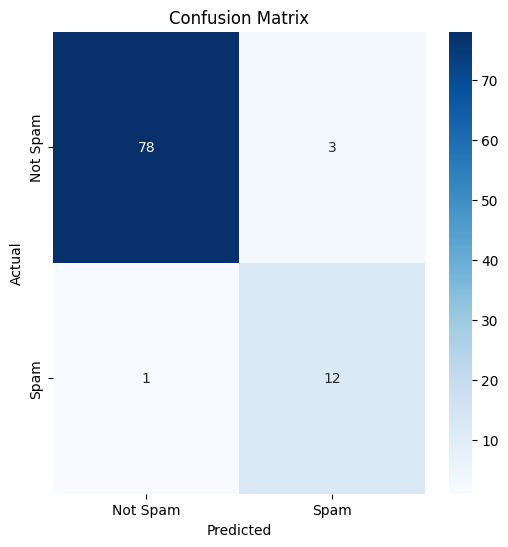

Confusion Matrix:
[[78  3]
 [ 1 12]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate the model
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print out the confusion matrix values
print("Confusion Matrix:")
print(cm)


In [ ]:
#@title tryinf different bert varities with hybrid approach using cnn

In [ ]:
#@title trying different bert approaches 3 epochs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, RobertaTokenizer, DistilBertTokenizer, AlbertTokenizer
from transformers import BertModel, RobertaModel, DistilBertModel, AlbertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
from tqdm import tqdm

# Define the hybrid Transformer + CNN model
class HybridTransformerModel(nn.Module):
    def __init__(self, model_name, num_labels=2):
        super(HybridTransformerModel, self).__init__()

        # Load the appropriate transformer model
        if "bert" in model_name:
            self.transformer = BertModel.from_pretrained(model_name)
            self.hidden_size = 768
        elif "roberta" in model_name:
            self.transformer = RobertaModel.from_pretrained(model_name)
            self.hidden_size = 768
        elif "distilbert" in model_name:
            self.transformer = DistilBertModel.from_pretrained(model_name)
            self.hidden_size = 768
        elif "albert" in model_name:
            self.transformer = AlbertModel.from_pretrained(model_name)
            self.hidden_size = 768  # Adjust if using a smaller ALBERT version

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=self.hidden_size, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128, num_labels)

    def forward(self, input_ids, attention_mask):
        transformer_output = self.transformer(input_ids, attention_mask=attention_mask if "distilbert" not in model_name else None)
        embeddings = transformer_output.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        embeddings = embeddings.permute(0, 2, 1)  # Reshape for CNN: (batch, hidden_size, seq_len)
        conv_output = torch.relu(self.conv1(embeddings))
        conv_output = torch.relu(self.conv2(conv_output))
        conv_output = torch.mean(conv_output, dim=2)  # Global Average Pooling

        output = self.fc(conv_output)  # Fully connected layer
        return output

# Load dataset
df = pd.read_csv("/content/spam_detected_modify.csv")  # Ensure your dataset has 'text' and 'is_spam' columns
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['is_spam'], test_size=0.2, random_state=42)

# Tokenizers for each model
tokenizers = {
    "bert": BertTokenizer.from_pretrained("bert-base-uncased"),
    "roberta": RobertaTokenizer.from_pretrained("roberta-base"),
    "distilbert": DistilBertTokenizer.from_pretrained("distilbert-base-uncased"),
    "albert": AlbertTokenizer.from_pretrained("albert-base-v2"),
}

# Function to tokenize text
def tokenize_texts(texts, tokenizer, max_len=128):
    return tokenizer(list(texts), padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")

# Training function
def train_model(model, train_dataloader, optimizer, criterion, device, epochs=3):
    model.train()
    model.to(device)
    for epoch in range(epochs):
        loop = tqdm(train_dataloader, leave=True)
        for batch in loop:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())

# Evaluation function
def evaluate_model(model, test_dataloader, device):
    model.eval()
    model.to(device)
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    return acc, f1, classification_report(true_labels, predictions)

# Model comparison
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_names = ["bert-base-uncased", "roberta-base", "distilbert-base-uncased", "albert-base-v2"]
results = []

for model_name in model_names:
    print(f"Training and evaluating {model_name}...")

    # Handle tokenizer mapping correctly
    model_prefix_map = {
        "bert": "bert",
        "roberta": "roberta",
        "distilbert": "distilbert",
        "albert": "albert"
    }
    model_key = next((key for key in model_prefix_map if key in model_name), None)
    tokenizer = tokenizers[model_key]

    # Tokenization
    train_encodings = tokenize_texts(X_train, tokenizer)
    test_encodings = tokenize_texts(X_test, tokenizer)

    # Creating datasets
    train_dataset = TensorDataset(
        train_encodings["input_ids"], train_encodings["attention_mask"], torch.tensor(y_train.values, dtype=torch.long)
    )
    test_dataset = TensorDataset(
        test_encodings["input_ids"], test_encodings["attention_mask"], torch.tensor(y_test.values, dtype=torch.long)
    )

    # Creating dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Initialize model
    model = HybridTransformerModel(model_name, num_labels=len(df["is_spam"].unique()))
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # Train & Evaluate
    train_model(model, train_dataloader, optimizer, criterion, device)
    acc, f1, report = evaluate_model(model, test_dataloader, device)

    print(f"Results for {model_name}:\n{report}\n")
    results.append({"Model": model_name, "Accuracy": acc, "F1 Score": f1})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)


Training and evaluating bert-base-uncased...


Epoch 3: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s, loss=0.0321]


Results for bert-base-uncased:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        81
           1       0.77      0.77      0.77        13

    accuracy                           0.94        94
   macro avg       0.87      0.87      0.87        94
weighted avg       0.94      0.94      0.94        94


Training and evaluating roberta-base...


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense

Results for roberta-base:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        81
           1       1.00      0.31      0.47        13

    accuracy                           0.90        94
   macro avg       0.95      0.65      0.71        94
weighted avg       0.91      0.90      0.88        94


Training and evaluating distilbert-base-uncased...


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.inte

Results for distilbert-base-uncased:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        81
           1       0.00      0.00      0.00        13

    accuracy                           0.86        94
   macro avg       0.43      0.50      0.46        94
weighted avg       0.74      0.86      0.80        94


Training and evaluating albert-base-v2...


You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dens

Results for albert-base-v2:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        81
           1       0.00      0.00      0.00        13

    accuracy                           0.86        94
   macro avg       0.43      0.50      0.46        94
weighted avg       0.74      0.86      0.80        94


                     Model  Accuracy  F1 Score
0        bert-base-uncased  0.936170  0.936170
1             roberta-base  0.904255  0.881431
2  distilbert-base-uncased  0.861702  0.797690
3           albert-base-v2  0.861702  0.797690


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-7-5a1d1c99dfd9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="Blues_r")
<ipython-input-7-5a1d1c99dfd9>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1 Score", data=results_df, palette="Oranges_r")


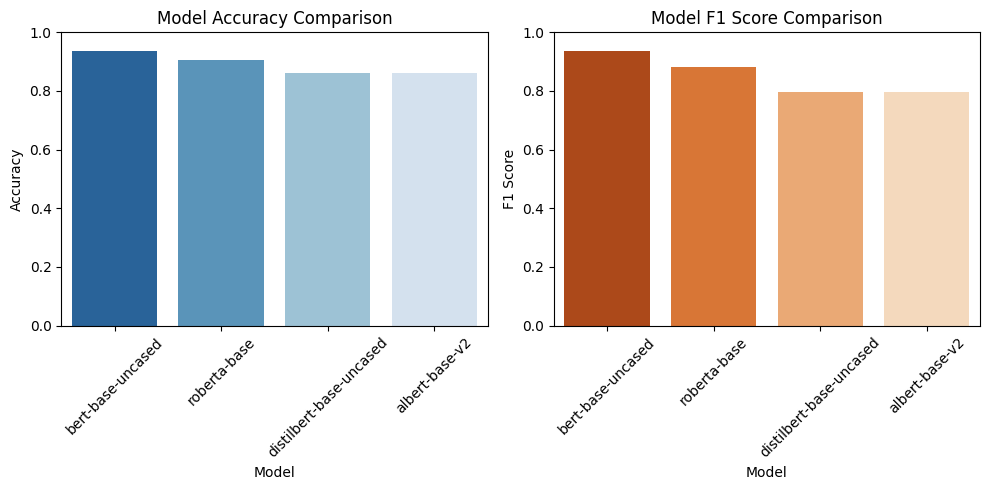

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot Accuracy and F1 Score
plt.figure(figsize=(10, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="Blues_r")
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)

# F1 Score Plot
plt.subplot(1, 2, 2)
sns.barplot(x="Model", y="F1 Score", data=results_df, palette="Oranges_r")
plt.xticks(rotation=45)
plt.title("Model F1 Score Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
#@title regular bert

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
from tqdm import tqdm

# Define Transformer-based Model (without CNN)
class BertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.fc = nn.Linear(768, num_labels)  # Classifier on top of BERT
        self.dropout = nn.Dropout(0.3)  # Regularization

    def forward(self, input_ids, attention_mask):
        transformer_output = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = transformer_output.pooler_output  # [batch_size, 768]
        output = self.dropout(pooled_output)
        output = self.fc(output)
        return output

# Load dataset
df = pd.read_csv("/content/spam_detected_modify.csv")  # Ensure dataset has 'text' and 'is_spam' columns
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['is_spam'], test_size=0.2, random_state=42)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize text
def tokenize_texts(texts, tokenizer, max_len=128):
    return tokenizer(list(texts), padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")

# Training function
def train_model(model, train_dataloader, optimizer, criterion, device, epochs=3):
    model.train()
    model.to(device)
    for epoch in range(epochs):
        loop = tqdm(train_dataloader, leave=True)
        for batch in loop:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())

# Evaluation function
def evaluate_model(model, test_dataloader, device):
    model.eval()
    model.to(device)
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    return acc, f1, classification_report(true_labels, predictions)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenization
train_encodings = tokenize_texts(X_train, tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)

# Creating datasets
train_dataset = TensorDataset(
    train_encodings["input_ids"], train_encodings["attention_mask"], torch.tensor(y_train.values, dtype=torch.long)
)
test_dataset = TensorDataset(
    test_encodings["input_ids"], test_encodings["attention_mask"], torch.tensor(y_test.values, dtype=torch.long)
)

# Creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize BERT model
model = BertClassifier(num_labels=len(df["is_spam"].unique()))
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Train & Evaluate
train_model(model, train_dataloader, optimizer, criterion, device)
acc, f1, report = evaluate_model(model, test_dataloader, device)

print(f"Results for BERT:\n{report}\n")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 3: 100%|██████████| 24/24 [00:07<00:00,  3.01it/s, loss=0.235]


Results for BERT:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87        81
           1       0.40      0.92      0.56        13

    accuracy                           0.80        94
   macro avg       0.69      0.85      0.71        94
weighted avg       0.90      0.80      0.83        94




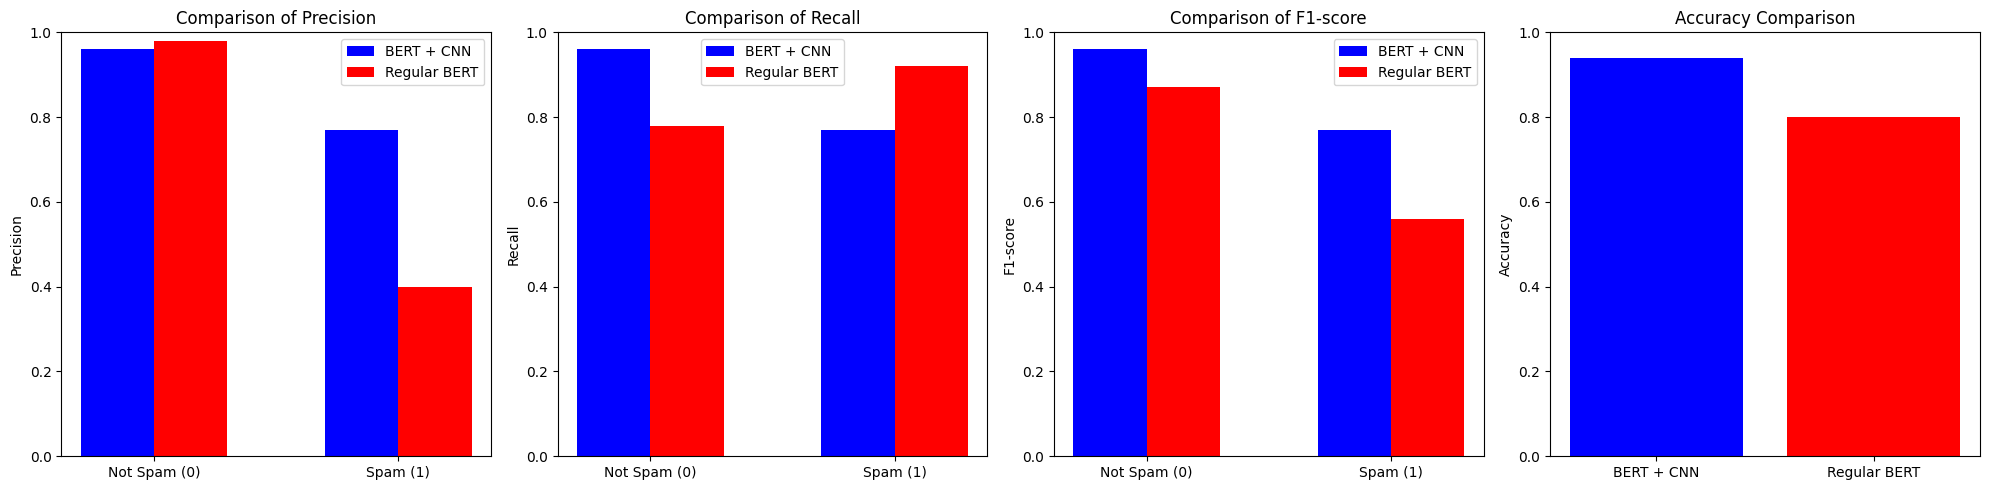

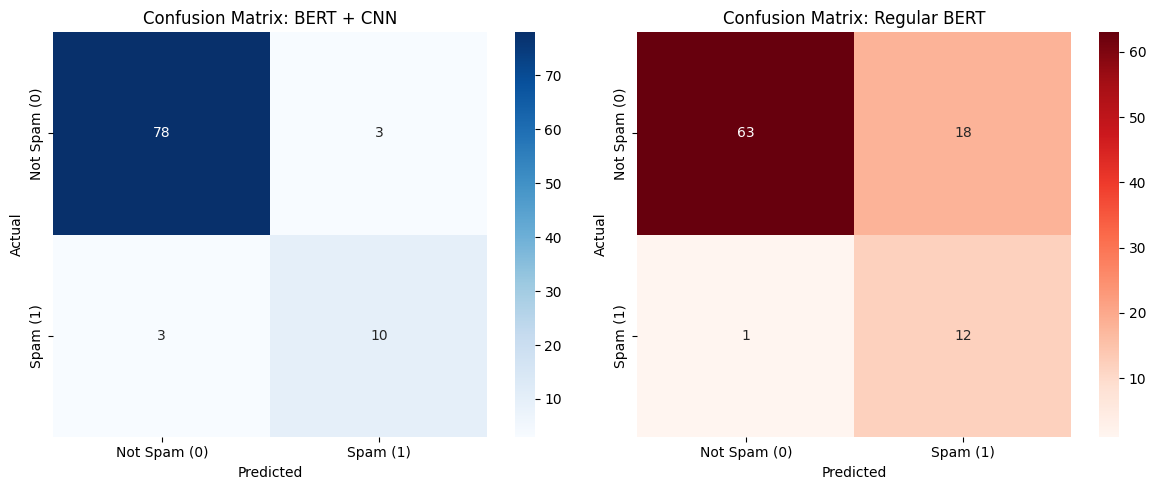

In [ ]:
#@title indpeth comparison about regular bert and hybrid bert with CNNN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Metrics from your results
labels = ["Not Spam (0)", "Spam (1)"]

bert_cnn_metrics = {
    "Precision": [0.96, 0.77],
    "Recall": [0.96, 0.77],
    "F1-score": [0.96, 0.77],
    "Accuracy": 0.94,
}

bert_metrics = {
    "Precision": [0.98, 0.40],
    "Recall": [0.78, 0.92],
    "F1-score": [0.87, 0.56],
    "Accuracy": 0.80,
}

# Plot Bar Graphs for Metrics Comparison
metrics = ["Precision", "Recall", "F1-score"]
x = np.arange(len(labels))
width = 0.3

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, metric in enumerate(metrics):
    axes[i].bar(x - width / 2, bert_cnn_metrics[metric], width, label="BERT + CNN", color="b")
    axes[i].bar(x + width / 2, bert_metrics[metric], width, label="Regular BERT", color="r")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel(metric)
    axes[i].set_title(f"Comparison of {metric}")
    axes[i].legend()

# Accuracy Bar Chart
axes[3].bar(["BERT + CNN", "Regular BERT"], [bert_cnn_metrics["Accuracy"], bert_metrics["Accuracy"]], color=["b", "r"])
axes[3].set_ylim(0, 1)
axes[3].set_ylabel("Accuracy")
axes[3].set_title("Accuracy Comparison")

plt.tight_layout()
plt.show()

# Confusion Matrices
bert_cnn_cm = np.array([[78, 3], [3, 10]])  # Replace with actual values
bert_cm = np.array([[63, 18], [1, 12]])     # Replace with actual values

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(bert_cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[0])
sns.heatmap(bert_cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels, ax=axes[1])

axes[0].set_title("Confusion Matrix: BERT + CNN")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

axes[1].set_title("Confusion Matrix: Regular BERT")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


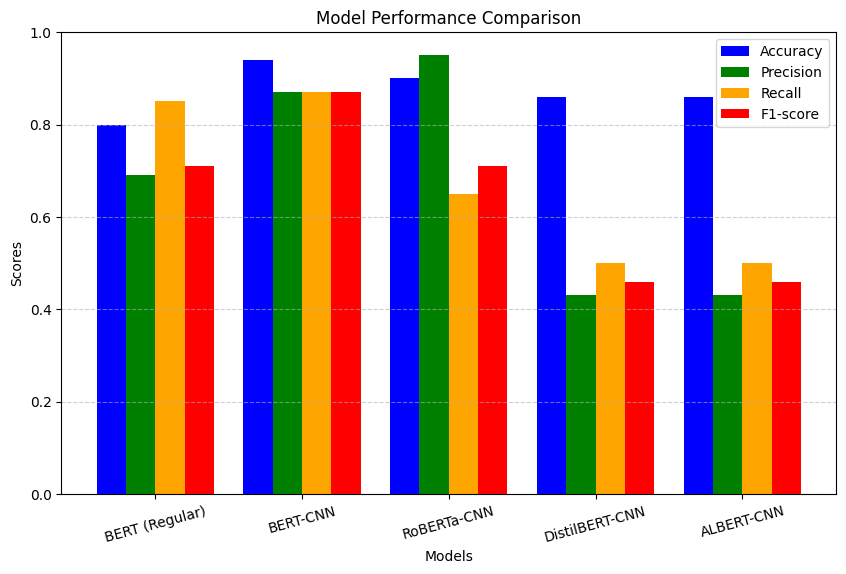

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Model Names
models = ["BERT (Regular)", "BERT-CNN", "RoBERTa-CNN", "DistilBERT-CNN", "ALBERT-CNN"]

# Metrics Data
accuracy = [0.80, 0.94, 0.90, 0.86, 0.86]
precision = [0.69, 0.87, 0.95, 0.43, 0.43]
recall = [0.85, 0.87, 0.65, 0.50, 0.50]
f1_score = [0.71, 0.87, 0.71, 0.46, 0.46]

# Bar Width
bar_width = 0.2
x = np.arange(len(models))

# Plot bars
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width*1.5, accuracy, width=bar_width, label="Accuracy", color="blue")
plt.bar(x - bar_width/2, precision, width=bar_width, label="Precision", color="green")
plt.bar(x + bar_width/2, recall, width=bar_width, label="Recall", color="orange")
plt.bar(x + bar_width*1.5, f1_score, width=bar_width, label="F1-score", color="red")

# Labels & Titles
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Model Performance Comparison")
plt.xticks(x, models, rotation=15)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()
